In [19]:
!pip install kaggle

In [20]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isapansoni","key":"eba442c4a0937cc8a4976bf639df91e9"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [22]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 244M/251M [00:01<00:00, 153MB/s]
100% 251M/251M [00:02<00:00, 131MB/s]


In [23]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: database.sqlite         
  inflating: hashes.txt              


In [0]:
%matplotlib inline
import time


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 ORDER BY Time ASC limit 10000
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [25]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,"this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses: i love all the new words this book introduces and the silliness of it all. this is a classic book i am willing to bet my son will STILL be able to recite from memory when he is in college"
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time with your child,"I can remember seeing the show when it aired on television years ago, when I was a child. My sister later bought me the LP (which I have to this day, I'm thirty something).I used this series of books &amp; songs when I did my student teaching for preschoolers &amp; turned the whole school on to it. I am now purchasing it on CD, along with the books for my children 5 &amp; 2. The tradition lives on!"
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime. Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull moment."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, starring michael keaton and geena davis in their prime. Tim Burton's masterpiece, rumbles with absurdity, and is wonderfully paced to the point where there is not a dull moment."


In [26]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left


#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


positive    6446
negative    830 
Name: Score, dtype: int64

In [27]:

import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import SpatialDropout1D


import re

Using TensorFlow backend.


In [0]:
data = final[['Text','Score']]

In [29]:
data['Text']= [x.lower() for x in data['Text']]
data['Text'] = data['Text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
pd.set_option('display.max_colwidth',-1)
data[:5]

,Text,Score
0,this witty little book makes my son laugh at loud i recite it in the car as were driving along and he always can sing the refrain hes learned about whales india drooping roses i love all the new words this book introduces and the silliness of it all this is a classic book i am willing to bet my son will still be able to recite from memory when he is in college,positive
1,i can remember seeing the show when it aired on television years ago when i was a child my sister later bought me the lp which i have to this day im thi y somethingi used this series of books amp songs when i did my student teaching for preschoolers amp turned the whole school on to it i am now purchasing it on cd along with the books for my children 5 amp 2 the tradition lives on,positive
298,this is a great little book to read aloud it has a nice rhythm as well as good repetition that little ones like in the lines about chicken soup with rice the child gets to go through the months of the year and go to wonderful places like bombay and down the nile all the while eating well you know what they get to eat some kids will have maurice sendaks version of ice skating or how to treat roses in their heads for a long time and they wont even know where it came from surprise it came from this little witty book,positive
1692,this is one of the best childrens books ever written but it is a mini version of the book and was not po rayed as one it is over priced for the product i sent an email regarding my bewilderment to amazon and got no response,negative
146,this book has been a favorite of mine since i was able to read it was one of my first introductions to poetry and the humorous rhymes have been an inspiration to me in my own writing this is the type of book that college students reminisce about and bond overit really is that simple and good,positive


In [0]:
Y = data['Score']
Y = Y.map({'positive': 1, 'negative': 0})
X = data['Text']


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3)

In [0]:
import keras
from keras.preprocessing import sequence
import numpy as np

tokenizer = keras.preprocessing.text.Tokenizer(num_words = 5000, split=' ')
tokenizer.fit_on_texts(X_train.values)
X_train_token = tokenizer.texts_to_sequences(X_train.values)
tokenizer.fit_on_texts(X_test.values)
X_test_token = tokenizer.texts_to_sequences(X_test.values)
max_review_length = 600
X_train_token = sequence.pad_sequences(X_train_token, maxlen=max_review_length)
X_test_token = sequence.pad_sequences(X_test_token, maxlen=max_review_length)


In [41]:
embed_dim = 128
lstm_out = 196
batch_size = 64

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X_train_token.shape[1], dropout = 0.2))
model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(32,activation='softmax'))
model.add(Dense(16,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 128)          256000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6304      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
Total params: 517,632
Trainable params: 517,632
Non-trainable params: 0
_________________________________________________________________
None


In [35]:

print(X_train_token.shape,Y_train.shape)
print(X_test_token.shape,Y_test.shape)

(5093, 600) (5093,)
(2183, 600) (2183,)


In [42]:
model_log = model.fit(X_train_token, Y_train, batch_size = batch_size, epochs = 5, verbose = 1,validation_data=(X_test_token, Y_test) )

Train on 5093 samples, validate on 2183 samples
Epoch 1/5
5093/5093 [==============================] - 140s 27ms/step - loss: 2.4121 - acc: 0.7940 - val_loss: 2.2065 - val_acc: 0.8956
Epoch 2/5
5093/5093 [==============================] - 139s 27ms/step - loss: 2.0710 - acc: 0.8818 - val_loss: 1.9223 - val_acc: 0.8956
Epoch 3/5
5093/5093 [==============================] - 139s 27ms/step - loss: 1.8136 - acc: 0.8818 - val_loss: 1.6860 - val_acc: 0.8956
Epoch 4/5
5093/5093 [==============================] - 139s 27ms/step - loss: 1.5948 - acc: 0.8818 - val_loss: 1.4820 - val_acc: 0.8956
Epoch 5/5
5093/5093 [==============================] - 139s 27ms/step - loss: 1.4061 - acc: 0.8818 - val_loss: 1.3062 - val_acc: 0.8956


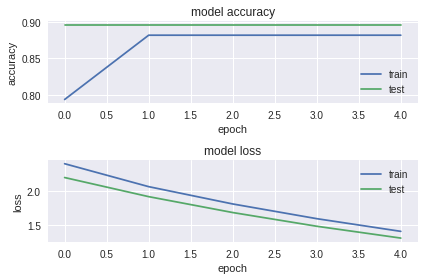

In [43]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [44]:
score,acc = model.evaluate(X_test_token, Y_test, verbose = 2, batch_size = batch_size)
print("Validation Accuracy: %.2f" % (acc))

Validation Accuracy: 0.90


# CONCLUSIONS

1.Created multi-layered LSTM RNN for the amazon food reviews data set for which for which we got quite good accuracy of 88 %